In [22]:
!pip install -Uq wandb
!export WANDB_API_KEY="e0aa96a51411bd4bc5a669e117bd1961648ff00e"

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: gaston-lm (carrostp3). Use `wandb login --relogin` to force relogin


True

In [4]:
# Importo las librerías necesarias.
import os
import gc
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchaudio.transforms as tt
from torchaudio.datasets import GTZAN
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive

In [5]:
# Utilizo GPU de estar disponible.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Seteo una semilla para replicabilidad.
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)

cpu


In [23]:
# Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos
drive.mount('/content/drive')
data_dir = '//content/drive/MyDrive/UTDT/TD6/genres_5sec/'
list_files = os.listdir(data_dir)

# Obtenemos las clases (géneros)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)

# Funciones auxiliares para la clase del dataset
samplerate=22050

# Para obtener generos
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Para definir transformación de audios (esto es data leakage hacerlo a todo? hay distintas formas: chequear clasificador.ipynb)
def transform(audio):
    return tt.Spectrogram()(audio)

# Definimos clase para obtener el dataset
class MusicDataset():
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.transform = tt.Spectrogram()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        spectrogram = self.transform(audio)

        return audio, spectrogram, class_idx

dataset = MusicDataset(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
audio, spec, _ = dataset[0]
import IPython
print(audio.size())
IPython.display.Audio(audio, rate=22050)

torch.Size([1, 110250])


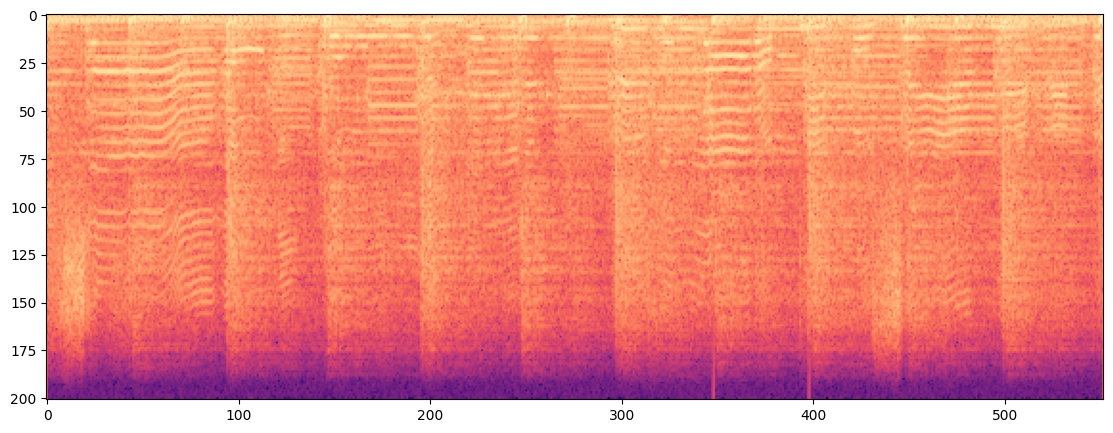

In [25]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.imshow(spec.log2()[0,:,:].numpy(),cmap='magma')

In [27]:
spec = transform(audio)
print(spec.size())
inverse = tt.InverseSpectrogram()
new_audio = inverse(spec.type(torch.complex64))
IPython.display.Audio(new_audio, rate=22050)

torch.Size([1, 201, 552])


In [34]:
three_dim_tensor = torch.randn(32, 141, 53)

# Reshape the 3D tensor to a 2D tensor
# The size argument in view is calculated as (batch_size, height * width)
m = nn.Flatten(1,-1)
two_dim_tensor = m(three_dim_tensor)

# Print the dimensions of the original and reshaped tensors
print("Original tensor size:", three_dim_tensor.size())
print("Reshaped tensor size:", two_dim_tensor.size())

Original tensor size: torch.Size([32, 141, 53])
Reshaped tensor size: torch.Size([32, 7473])


In [ ]:
# Definición del encoder
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=2, stride=2, padding=2),
            nn.ReLU()
        )
        self.latent_space = nn.Flatten()

    def forward(self, x):
        x = self.encoder(x)
        latent_rep = self.latent_space(x)
        print(latent_rep.size())
        return latent_rep

# Definición del decoder
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size):
        super(Decoder, self).__init__()
        self.unflatten = nn.Unflatten(1, (64, 13782))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 8, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.unflatten(x)
        # Adjust the size of the unflattened tensor to match the expected input size
        x = x.view(-1, 64, 13782)
        reconstructed_seq = self.decoder(x)
        return reconstructed_seq

# Definición del Convolutional Autoencoder (CAE)
class CAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(CAE, self).__init__()
        self.encoder = Encoder(input_size, latent_size)
        self.decoder = Decoder(latent_size, input_size)

    def forward(self, x):
        latent_rep = self.encoder(x)
        reconstructed_seq = self.decoder(latent_rep)
        return reconstructed_seq, latent_rep

In [ ]:
audio, spec, label = dataset[0]

# Hiperparámetros
batch_size = 20
learning_rate = 0.02
epochs = 40
type_input = 'spectrogram' # podría ser sino 'waveform' --> ajustar transform arriba
input_size = (batch_size, 201, 552) # en base al tamaño del tensor de audio
latent_size = 1
experiment_name = 'spec_test'
project_name = 'TP4'

# Definición del modelo
model = CAE(input_size, latent_size)
model.to(device)
print(model)

# Configuración de wandb
wandb.init(
    project = project_name,
    name = experiment_name,
    config = {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "type_input": type_input,
        "latent_size": latent_size
    }
)

CAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(5,), stride=(2,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
      (5): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_space): Linear(in_features=882048, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (latent_space): Linear(in_features=64, out_features=882048, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 13782))
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (1): ReLU()
      (2): ConvTranspose1d(32, 16, kernel_size=(5,), stride=(2,), padding=(2,))
      (3): ReLU()
      (4): ConvTranspose1d(16, 1, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    )
  )
)


In [ ]:
# Divido en training, validation, testing.
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = td.random_split(dataset, [train_size, val_size, test_size])

train_dl = td.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = td.DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = td.DataLoader(test_ds,1, num_workers=2, pin_memory=True)

In [ ]:
# Definición de función de perdida (MSE loss la que se suele usar para reconstrucción)
criterion = nn.MSELoss()
# Definición del optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Importante para ir liberando memoria ram
torch.cuda.empty_cache()
gc.collect()

lowest_loss = 1
best_epoch = -1

for epoch in range(epochs):
    train_losses = []
    # Entrenamiento
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()  # Clear gradients

        inputs, _ = batch
        inputs = inputs.to(device)

        # Forward pass
        outputs, _ = model(inputs)

        # Compute reconstruction loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Importante para ir liberando memoria ram
        del inputs
        del loss
        del outputs
        torch.cuda.empty_cache()
        gc.collect()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in valid_dl:
            inputs, _ = batch
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            val_losses.append(loss.item())

    # Importante para ir liberando memoria ram
    del inputs
    del loss
    del outputs
    torch.cuda.empty_cache()
    gc.collect()

    # Para estadisticas de wandb
    if val_losses[-1] < lowest_loss:
        lowest_loss = val_losses[-1]
        best_epoch = epoch
        best_model_state_dict = model.state_dict()

    wandb.log({"train_loss": train_losses[-1], "val_loss": val_losses[-1]})

    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')

# Indico por consola cuando finalizó el entrenamiento
print(f"Entrenamiento finalizado, la loss más baja fue {str(lowest_loss)} la mejor epoch:{str(best_epoch)}")

wandb.log({"lowest_loss": lowest_loss, "best_epoch": best_epoch})

# Guardo el modelo entrenado en disco
PATH = './cae.pth'
torch.save(best_model_state_dict, PATH)
wandb.finish()

Epoch [1/40], Training Loss: 8107.3637, Validation Loss: 0.0620
Epoch [2/40], Training Loss: 5.9732, Validation Loss: 0.1658
Epoch [3/40], Training Loss: 0.2190, Validation Loss: 0.1810
Epoch [4/40], Training Loss: 0.1153, Validation Loss: 0.0671
Epoch [5/40], Training Loss: 0.0468, Validation Loss: 0.0443
Epoch [6/40], Training Loss: 0.0402, Validation Loss: 0.0448
Epoch [7/40], Training Loss: 0.0408, Validation Loss: 0.0446
Epoch [8/40], Training Loss: 0.0399, Validation Loss: 0.0443
Epoch [9/40], Training Loss: 0.0397, Validation Loss: 0.0439
Epoch [10/40], Training Loss: 0.0391, Validation Loss: 0.0435
Epoch [11/40], Training Loss: 0.0390, Validation Loss: 0.0431
Epoch [12/40], Training Loss: 0.0383, Validation Loss: 0.0426
Epoch [13/40], Training Loss: 0.0377, Validation Loss: 0.0422
Epoch [14/40], Training Loss: 0.0375, Validation Loss: 0.0419
Epoch [15/40], Training Loss: 0.0370, Validation Loss: 0.0415
Epoch [16/40], Training Loss: 0.0367, Validation Loss: 0.0412
Epoch [17/40],

best_epoch,▁
lowest_loss,▁
train_loss,▂▆█▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁
val_loss,▂▇█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,39
lowest_loss,0.03508
train_loss,0.03002
val_loss,0.03508


In [ ]:
# Load the best model
S = torch.load('cae.pth')
model.load_state_dict(S)

model.eval()

reconstructed_wavs_list = []

for wav, _ in test_dl:
    audio = wav.to(device)

    with torch.no_grad():
        # Forward pass
        reconstructed_output, _ = model(audio)

        # Save the reconstructed output to the list
        reconstructed_wavs_list.append(reconstructed_output.squeeze(0).cpu().numpy())

In [ ]:
original_wav, _ = test_dl.dataset[5]
reconstructed_wav = reconstructed_wavs_list[5]

In [ ]:
reconstructed_wav.shape

(1, 110250)

In [ ]:
import IPython
IPython.display.Audio(original_wav, rate=22050)

In [ ]:
IPython.display.Audio(reconstructed_wav, rate=22050)